<div class="notebook-buttons" style="display:flex; padding-top: 5rem;padding-bottom: 2.5rem;line-height: 2.15;">
    <a href="https://colab.research.google.com/github/zazuko/notebooks/blob/master/notebooks/electricity_prices/tariffs_increase.ipynb">
        <div id="colab-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; align-items: center;">
            <img class="call-to-action-img" src="img/colab.svg" width="30" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Run in Google Colab</div>
        </div>
    </a>
    <a href="https://raw.githubusercontent.com/zazuko/notebooks/master/notebooks/electricity_prices/tariffs_increase.ipynb" download>
        <div id="download-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img/download.svg" width="22" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">Download Notebook</div>
        </div>
    </a>
    <a href="https://github.com/zazuko/notebooks/blob/master/notebooks/electricity_prices/tariffs_increase.ipynb">
        <div id="github-link" style="display: flex;padding-right: 3.5rem;padding-bottom: 0.625rem;border-bottom: 1px solid #ececed; height: auto;align-items: center;">
            <img class="call-to-action-img" src="img/github.svg" width="25" height="30" style="margin-right: 10px;margin-top: auto;margin-bottom: auto;">
            <div class="call-to-action-txt">View on GitHub</div>
        </div>
    </a>
</div>

# How much will you pay for electricity next year?

ElCom, the Federal Electricity Commission, collects data on the electricity tariffs for household and companies. This data is published as [Linked Data](https://en.wikipedia.org/wiki/Linked_data). 

In this data story, we will show you how to calculate your electricity bills for next year **using Linked Data.** Mainly, you will see how to extract, process, and interpret with data on electricity tariffs.   

Enjoy the ride!

In [74]:
import json
import re
import string

import branca.colormap as cm
import folium
import mapclassify
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd

from graphly.api_client import SparqlClient

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [75]:
# Uncomment to install dependencies in Colab environment
#!pip install mapclassify
#!pip install git+https://github.com/zazuko/graphly.git

### SPARQL endpoints

#### For electricity tariffs
Data on all electricity tariffs is published as Linked Data. It can be accessed with [SPARQL queries](https://www.w3.org/TR/rdf-sparql-query/).   
You can send queries using HTTP requests. The API endpoint is **[https://lindas.admin.ch/query/](https://int.lindas.admin.ch/query).**  

#### For geodata
Different municipalities may have different tariffs. To understand their location, we will work with 
Swiss geodata. It is published as Linked Data. It can be accessed using API endpoint under **[https://ld.geo.admin.ch/query](https://ld.geo.admin.ch/query).**  

In [76]:
sparql = SparqlClient("https://lindas.admin.ch/query")
geosparql = SparqlClient("https://ld.geo.admin.ch/query")

sparql.add_prefixes({
    "schema": "<http://schema.org/>",
    "cube": "<https://cube.link/>",
    "elcom": "<https://energy.ld.admin.ch/elcom/electricityprice/dimension/>",
    "admin": "<https://schema.ld.admin.ch/>"
})

geosparql.add_prefixes({
    "dct": "<http://purl.org/dc/terms/>",
    "geonames": "<http://www.geonames.org/ontology#>",
    "schema": "<http://schema.org/>",
    "geosparql": "<http://www.opengis.net/ont/geosparql#>",
})

### What do you want to know? 
Define your parameters here: consumer category, current year, and upcoming year.

In [77]:
category = "H2"
year_old = 2022
year_new = 2023

Wonder what categories you can choose from?

Check it out [here](https://s.zazuko.com/Zod6w)!

## Retriving the data

Here is where the magic happens. Using SPARQL endpoint, you will be able to get data on electricity prices in all swiss communes in single SPARQL query!


In [78]:
query = """
SELECT ?municipality_id ?increase ?fixcosts_old ?fixcosts_new ?price_old ?price_new ?elcom_details
FROM <https://lindas.admin.ch/elcom/electricityprice>
FROM <https://lindas.admin.ch/territorial>
WHERE {{
    <https://energy.ld.admin.ch/elcom/electricityprice/observation/> cube:observation ?observation_old.
    <https://energy.ld.admin.ch/elcom/electricityprice/observation/> cube:observation ?observation_new.
  
  VALUES ?category {{ <https://energy.ld.admin.ch/elcom/electricityprice/category/{0}>}}
    ?observation_new
      elcom:category ?category;
      elcom:municipality ?municipality_id;
      elcom:period "{1}"^^<http://www.w3.org/2001/XMLSchema#gYear>;
      elcom:product <https://energy.ld.admin.ch/elcom/electricityprice/product/standard>;
      elcom:fixcosts ?fixcosts_new;
      elcom:total ?variablecosts_new.
  
    ?observation_old
      elcom:category ?category;
      elcom:municipality ?municipality_id;
      elcom:period "{2}"^^<http://www.w3.org/2001/XMLSchema#gYear>;
      elcom:product <https://energy.ld.admin.ch/elcom/electricityprice/product/standard>;
      elcom:fixcosts ?fixcosts_old;
      elcom:total ?variablecosts_old.
  
  ?municipality_id schema:name ?municipality ;
                   schema:identifier ?mun_num .

  BIND(IRI(CONCAT("https://www.strompreis.elcom.admin.ch/municipality/", STR(?mun_num), "?period={2}")) AS ?elcom_details )
  
  BIND((?variablecosts_new/?variablecosts_old - 1)*100 AS ?increase)
  BIND(?variablecosts_old/100 AS ?price_old)
  BIND(?variablecosts_new/100 AS ?price_new)
}}
""".format(category, year_new, year_old)

tariffs = sparql.send_query(query)
tariffs = tariffs.groupby(["municipality_id"]).min().reset_index().sort_values(by="increase", ascending=False)
tariffs.head()

Great! We can analyse all price components across municipalities and consumption categories. Do you want to play around?
Check out our query [here](https://s.zazuko.com/bR1uXZ)

But what our consumption category stands for?

In [79]:
query = """
SELECT *
WHERE {{
  GRAPH <https://lindas.admin.ch/elcom/electricityprice> {{
    
    <https://energy.ld.admin.ch/elcom/electricityprice/category/{0}> schema:description ?description .
  }}
}}
""".format(category)
cat_description = sparql.send_query(query)["description"].iloc[0]
cat_description

"2'500 kWh/Jahr: 4-Zimmerwohnung mit Elektroherd"

In [80]:
def extract_consumption(description: str) -> int:
    """
    Extract average electricity consumption from a description.
    Args:
        description:  Category description for electricity tariffs
        
    Returns: 
        int:          Electricity consumption in kWh/year
    
    """
    
    number_as_string = description.split(" kWh/Jahr")[0]
    return int(number_as_string.translate(str.maketrans('', '', string.punctuation)))

consumption = extract_consumption(cat_description)
tariffs["monthly_bill_old"] = ((consumption*tariffs.price_old/12 + tariffs.fixcosts_old)).round(2)
tariffs["monthly_bill_new"] = ((consumption*tariffs.price_new/12 + tariffs.fixcosts_new)).round(2)
tariffs["price_old"] = tariffs["price_old"].round(2)
tariffs["price_new"] = tariffs["price_new"].round(2)
tariffs.increase = tariffs.increase.round(0)

Electricity prices vary across municipalities. The `tariff` table gives us an overview of prices at each municipality. But what are their names? Where are they located? 

This information can be obtained using the SPARQL Endpoind from Swisstopo, Switzerland's national mapping agency.
We can query the list of municipalities, alongside with its boundaries as follows:

In [81]:
query = """    
SELECT ?municipality_id ?municipality ?population ?boundary 

WHERE {{
  ?muni_iri dct:hasVersion ?version ;
            geonames:featureCode geonames:A.ADM3 .
  
  ?version schema:validUntil "{}-12-31"^^<http://www.w3.org/2001/XMLSchema#date>;
           geonames:population ?population;
           schema:name ?municipality;
           geosparql:hasGeometry/geosparql:asWKT ?boundary.
  
  BIND(IRI(REPLACE(STR(?muni_iri), "https://ld.geo.admin.ch/boundaries/", "https://ld.admin.ch/")) AS ?municipality_id)
}}

""".format(year_old)
communes = geosparql.send_query(query)
communes = communes.set_crs(epsg=4326)
join = pd.merge(communes[["municipality_id", "municipality", "population", "boundary"]], tariffs, how="left", on="municipality_id")

## How much are you paying now?

Let's take a look at average monthly bill for a household. How much was it in 2022? How much will in be next year?

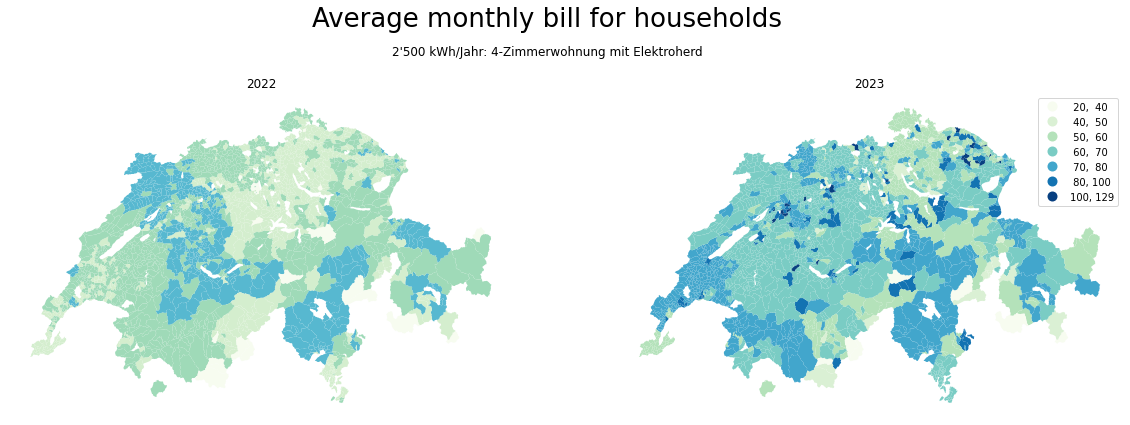

In [132]:
cols=["monthly_bill_old", "monthly_bill_new"]
years = [year_old, year_new]
fig, axs = plt.subplots(1, len(cols), figsize=(20,8))

for i, (year, col) in enumerate(zip(years, cols)):

    if i == 0:
        has_legend = False
    else:
        has_legend = True
    join.plot(ax=axs[i], column=col, cmap="GnBu", scheme="User_Defined", classification_kwds=dict(bins=[40,50,60,70,80,100]), legend=has_legend, legend_kwds={"fmt": "{:.0f}"})
    axs[i].set_axis_off()
    axs[i].set_title(year)
        
plt.text(x=0.5, y=0.90, s="Average monthly bill for households", fontsize=26, ha="center", transform=fig.transFigure)
plt.text(x=0.5, y=0.85, s= cat_description, fontsize=12, ha="center", transform=fig.transFigure)
plt.show()


## How much will you pay next year?

On the first glimpsee, you will spot significant increases. How big are they exactly?

And what does that mean for your households in your commune?

In [88]:
colors = ['#006d2c', '#74c476', '#ffffb2','#fed976','#feb24c','#fd8d3c','#f03b20','#bd0026']
BINS=[-79, -25, 0, 25, 50, 75, 100, 150]
colormap = cm.StepColormap(colors,
                       vmin=-79, vmax=275, index=BINS,
                       caption='Price increase in %')

style_function = lambda x: {"weight":0.1, 
                            'color':'#000000',
                            'fillColor': colormap(x['properties']['increase']) if x['properties']['increase'] else '#fafafa', 
                            'fillOpacity': 1}
                        

highlight_function = lambda x: {'fillColor': '#989898', 
                                'color':'#000000', 
                                'fillOpacity': 0.8}

def plot_tariffs(df, variables, variables_description, title):
    
    classifier = mapclassify.UserDefined(y=df[variables[0]], bins = BINS)
    bins = [df[variables[0]].min()] + list(classifier.bins)

    m = folium.Map(location=[46.83, 8.13], zoom_start=7.5, tiles="cartodbpositron")

    folium.Choropleth(
        geo_data=json.loads(df.to_json()),
    ).add_to(m)

    hover_has_data = folium.features.GeoJson(
        df[~df.increase.isna()],
        style_function=style_function, 
        control=False,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(
            fields=['municipality', *variables],
            aliases=['Municipality: '] + [v + ": " for v in variables_description],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
        )
    )

    hover_missing_data = folium.features.GeoJson(
        df[df.increase.isna()],
        style_function=style_function, 
        control=False,
        highlight_function=highlight_function,
        tooltip=folium.features.GeoJsonTooltip(
            fields=['municipality'],
            aliases=['Municipality: '],
            style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
        ),
    )
    colormap.add_to(m)
    m.add_child(hover_has_data)
    m.add_child(hover_missing_data)
    m.keep_in_front(hover_has_data)
    
    title_html = '''<h3 align="center" style="font-size:22px"><b>How much will your electricity bill be next year?</b><br></h3><p align="center">{}</p>'''.format(title)   
    m.get_root().html.add_child(folium.Element(title_html))

    return m

In [89]:
variables=["increase", "price_old", "price_new", "monthly_bill_old", "monthly_bill_new", "elcom_details"]
description = ["Price increase [%]", "Price in {} [CHF/kWh]".format(year_old), "Price in {} [CHF/kWh]".format(year_new), "Avg monthly bill in {} [CHF]".format(year_old), "Avg monthly bill in {} [CHF]".format(year_new), "Details"]
plot_tariffs(join, variables, description, cat_description)

Et volià! All price increases happening next year.

### Let's talk

Do you know what to expect in January? How big will your bill be next year? Let us know at [@zazukocom](https://twitter.com/zazukocom)! 

### Want to know more about linked data?
We help companies leverage their data with Lined Data. With graph technology, building use cases like this becomes quick and simple. 
Have you noticed how we got all data, for all electricity providers, across all regions, in a single database query?

No looking for right datasets. No data cleanig and wrangling. Just exploring.
Imagine, just imagine, what it could do in your company.

Want to know more? [Let's talk](https://zazuko.com/about/).

